<a href="https://colab.research.google.com/github/loooxy/ML/blob/main/%D0%A4%D0%B5%D0%B4%D1%8E%D0%BD%D0%B8%D0%BD_%D0%92%D0%92%D0%A1_%D0%94%D0%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST handwritten digits classification with MLPs

В этом ноутбуке мы решим задачу классификации цифр из датасета MNIST, используя **PyTorch**.

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1+cu118  Device: cuda


## Data

In [ ]:
batch_size = 32

train_dataset = datasets.CIFAR100('./data',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

validation_dataset = datasets.CIFAR100('./data',
                                    train=False,
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

100%|██████████| 169001437/169001437 [00:10<00:00, 16137828.91it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [ ]:
X_train.shape

torch.Size([32, 3, 32, 32])

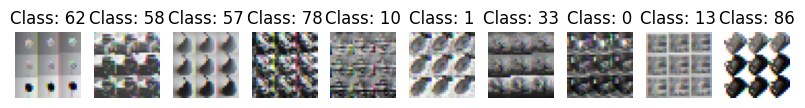

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(32, 32, 3))
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 100)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, len(train_dataset.classes))

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

In [ ]:
model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
)


## Learning

In [ ]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


In [ ]:
%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.596442
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.592906
Train Epoch: 1 [12800/50000 (26%)]	Loss: 4.208647
Train Epoch: 1 [19200/50000 (38%)]	Loss: 4.443825
Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.373820
Train Epoch: 1 [32000/50000 (64%)]	Loss: 4.432395
Train Epoch: 1 [38400/50000 (77%)]	Loss: 4.360428
Train Epoch: 1 [44800/50000 (90%)]	Loss: 4.426547

Validation set: Average loss: 4.2189, Accuracy: 380/10000 (4%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.187356
Train Epoch: 2 [6400/50000 (13%)]	Loss: 4.166458
Train Epoch: 2 [12800/50000 (26%)]	Loss: 4.312540
Train Epoch: 2 [19200/50000 (38%)]	Loss: 4.113895
Train Epoch: 2 [25600/50000 (51%)]	Loss: 4.487832
Train Epoch: 2 [32000/50000 (64%)]	Loss: 4.212229
Train Epoch: 2 [38400/50000 (77%)]	Loss: 4.037125
Train Epoch: 2 [44800/50000 (90%)]	Loss: 4.290165

Validation set: Average loss: 4.1766, Accuracy: 565/10000 (6%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 4.414817
Train Epoch: 3 [6400/50000 (13%)]	Los

# Visualization

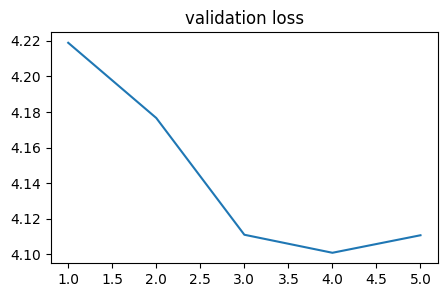

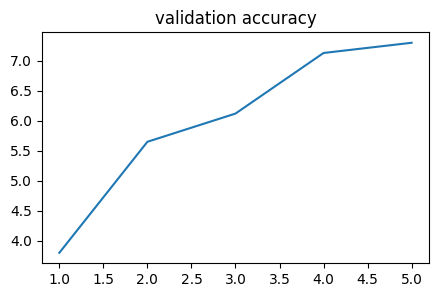

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

# CNN Network defenition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)


In [ ]:
%%time
epochs = 100

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.586910
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.364691
Train Epoch: 1 [12800/50000 (26%)]	Loss: 4.407499
Train Epoch: 1 [19200/50000 (38%)]	Loss: 4.139686
Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.277100
Train Epoch: 1 [32000/50000 (64%)]	Loss: 4.157019
Train Epoch: 1 [38400/50000 (77%)]	Loss: 4.245261
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.877830

Validation set: Average loss: 4.1117, Accuracy: 783/10000 (8%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.909909
Train Epoch: 2 [6400/50000 (13%)]	Loss: 4.041759
Train Epoch: 2 [12800/50000 (26%)]	Loss: 3.720574
Train Epoch: 2 [19200/50000 (38%)]	Loss: 3.932330
Train Epoch: 2 [25600/50000 (51%)]	Loss: 3.983215
Train Epoch: 2 [32000/50000 (64%)]	Loss: 3.493618
Train Epoch: 2 [38400/50000 (77%)]	Loss: 4.119673
Train Epoch: 2 [44800/50000 (90%)]	Loss: 3.941616

Validation set: Average loss: 3.7846, Accuracy: 1258/10000 (13%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.579318
Train Epoch: 3 [6400/50000 (13%)]	L

KeyboardInterrupt: ignored

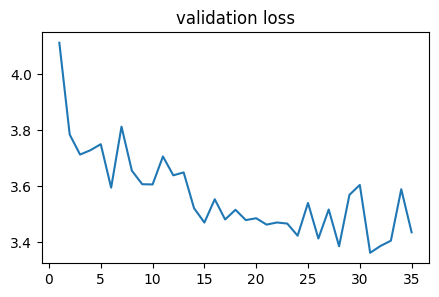

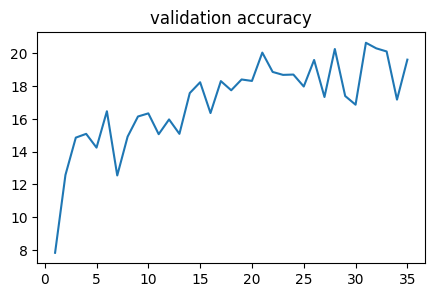

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,35+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,35+1), accv)
plt.title('validation accuracy');

# CNN Network from Network Zoo

In [ ]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 100)
# for name, parametrs in model.
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 3.276104
Train Epoch: 1 [6400/50000 (13%)]	Loss: 3.334907
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.830607
Train Epoch: 1 [19200/50000 (38%)]	Loss: 3.489457
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.835373
Train Epoch: 1 [32000/50000 (64%)]	Loss: 3.304956
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.734730
Train Epoch: 1 [44800/50000 (90%)]	Loss: 3.020090

Validation set: Average loss: 3.2144, Accuracy: 2142/10000 (21%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.788478
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.852748
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.831886
Train Epoch: 2 [19200/50000 (38%)]	Loss: 3.025918
Train Epoch: 2 [25600/50000 (51%)]	Loss: 3.407768
Train Epoch: 2 [32000/50000 (64%)]	Loss: 3.277562
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.555175
Train Epoch: 2 [44800/50000 (90%)]	Loss: 3.571566

Validation set: Average loss: 3.0883, Accuracy: 2409/10000 (24%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.946742
Train Epoch: 3 [6400/50000 (13%)]

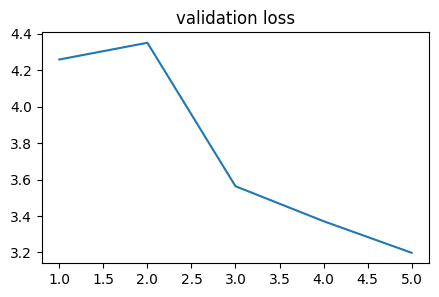

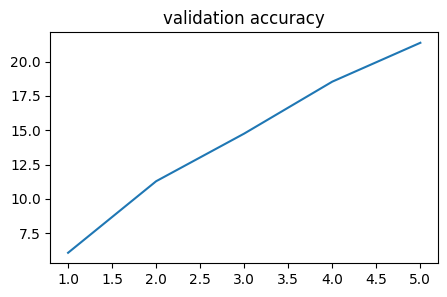

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');